In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_fname = 'C:/Windows/Fonts/H2GTRM.ttf'
font_family = fm.FontProperties(fname=font_fname).get_name()
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = font_family

In [2]:
data = pd.read_csv('FrenchFoodData.csv')
data.head()

,TYPE,BREAD,VEGETABLES,FRUITS,MEAT,POULTRY,MILK,WINE
0,MA2,332,428,354,1437,526,247,427
1,EM2,293,559,388,1527,567,239,258
2,CA2,372,767,562,1948,927,235,433
3,MA3,406,563,341,1507,544,324,407
4,EM3,386,608,396,1501,558,319,363


In [3]:
data = pd.read_csv('FrenchFoodData.csv')
data['TYPE'] = [item[:-1] for item in data['TYPE']]
data.head()
data_ch = pd.read_csv('FrenchFoodData.csv')
data_ch['CHILD'] = [item[-1] for item in data_ch['TYPE']]
data_ch.head()
data_ch.drop(['TYPE'], inplace = True, axis = 1)

In [4]:
df = data.set_index('TYPE').copy()
df.head()

,BREAD,VEGETABLES,FRUITS,MEAT,POULTRY,MILK,WINE
TYPE,,,,,,,
MA,332,428,354,1437,526,247,427
EM,293,559,388,1527,567,239,258
CA,372,767,562,1948,927,235,433
MA,406,563,341,1507,544,324,407
EM,386,608,396,1501,558,319,363


df는 전체 데이터셋, df1은 육체노동자 데이터셋, df2는 회사원(화이트칼라?) 데이터셋, df3는 매니저 데이터셋

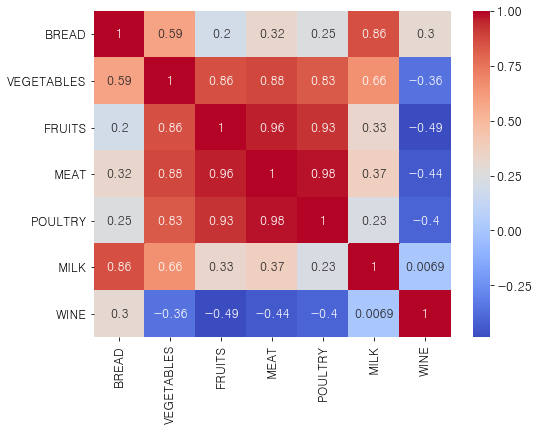

In [5]:
corr_mat = df.corr()
plt.figure(figsize = (8, 6))
sns.heatmap(corr_mat, annot = True, cmap = 'coolwarm')
plt.show()

빵과 우유사이 높은 상관관계(주식) / 채소 - 과일 - 고기 - 가금류 - 와인 높은 상관관계 근데 와인만 음의 상관관계네용

In [6]:
for i in range(7):
    q1 = np.percentile(df.iloc[:,i], 25)
    q3 = np.percentile(df.iloc[:,i], 75)
    iqr = (q3 - q1) * 1.5
    for j in range(df.shape[0]):
        if df.iloc[:,i][j] < q1 - iqr or df.iloc[:,i][j] > q3 + iqr:
            df.iloc[:,i][j] = np.percentile(df.iloc[:,i], 50)
            print('{} has an outlier, so we have imputed it as median'.format(df.columns[i]))

FRUITS has an outlier, so we have imputed it as median


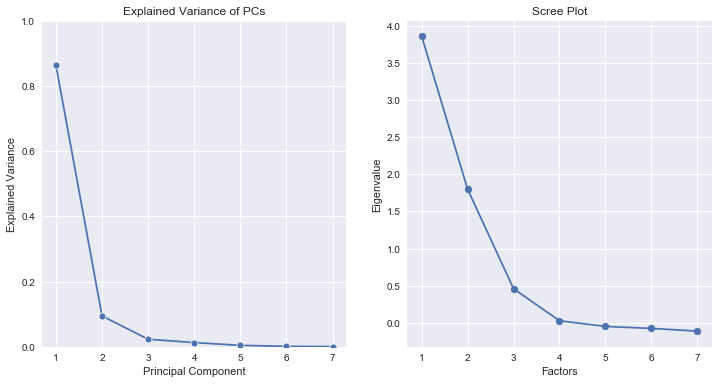

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
pca = PCA()
pca.fit(df)
plt.figure(figsize = (12,6))
plt.style.use('seaborn')
lambdas = pca.explained_variance_ratio_
plt.subplot(1, 2, 1)
sns.lineplot(x = [1,2,3,4,5,6,7],y  = lambdas, marker = 'o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.ylim((0, 1))
plt.title('Explained Variance of PCs')
plt.grid(True)

fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax', bounds = (0, 1), method = 'principal')
fa.fit(df_scaled)
plt.subplot(1, 2, 2)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1,df.shape[1]+1),v)
plt.plot(range(1,df.shape[1]+1),v)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.style.use('seaborn')

plt.savefig('screeplot.png')
plt.show()

In [8]:
x = pd.DataFrame(np.round(fa.loadings_.T, 2), columns = df.columns)
x.columns = ['빵 섭취량','야채 섭취량', '과일 섭취량', '육류 섭취량', '가금류 섭취량', '우유 섭취량', '와인 섭취량']
x
new = np.array([x.values[0], x.values[1],np.round(fa.get_communalities(),2)])
new = pd.DataFrame(new, columns = x.columns)
new.index = ['Loading1','Loading2','Communality']
new

,빵 섭취량,야채 섭취량,과일 섭취량,육류 섭취량,가금류 섭취량,우유 섭취량,와인 섭취량
Loading1,0.02,0.74,0.87,0.92,0.95,0.06,-0.63
Loading2,0.96,0.63,-0.05,0.34,0.24,0.94,0.26
Communality,0.93,0.95,0.76,0.96,0.95,0.89,0.46


In [9]:
print(0.63**2+0.26**2)

0.4645


In [10]:
pd.Series(np.round(fa.get_communalities(),2), index = df.columns)

BREAD         0.93
VEGETABLES    0.95
FRUITS        0.76
MEAT          0.96
POULTRY       0.95
MILK          0.89
WINE          0.46
dtype: float64

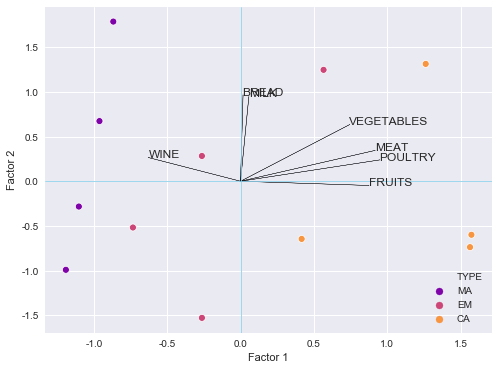

In [11]:
plt.figure(figsize = (8, 6))
for i in range(7):
    if i == 0:
        plt.arrow(0, 0, fa.loadings_.T[0,i], fa.loadings_.T[1,i])
        plt.text(fa.loadings_.T[0,i] * 0.7, fa.loadings_.T[1,i], s = df.columns[i])
    else:
        plt.arrow(0, 0, fa.loadings_.T[0,i], fa.loadings_.T[1,i])
        plt.text(fa.loadings_.T[0,i] , fa.loadings_.T[1,i], s = df.columns[i])
        

plt.axvline(x =0, color = 'skyblue', linewidth = .8)
plt.axhline(y =0, color = 'skyblue', linewidth = .8)
plt.xlabel('Factor1')
plt.ylabel('Factor2')

fa_df = fa.fit_transform(df_scaled)[:,0:2]
fa_df = pd.DataFrame(data = fa_df
             , columns = ['Factor 1', 'Factor 2'])
status = data.loc[:,'TYPE']
status = pd.DataFrame(status, columns = ['TYPE'])
fa_df['TYPE'] = status
sns.scatterplot(x = 'Factor 1', y = 'Factor 2', data = fa_df, hue = 'TYPE', palette = 'plasma')
plt.legend(loc = 'lower right')


In [12]:
fa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
Factor 1    12 non-null float64
Factor 2    12 non-null float64
TYPE        12 non-null object
dtypes: float64(2), object(1)
memory usage: 368.0+ bytes


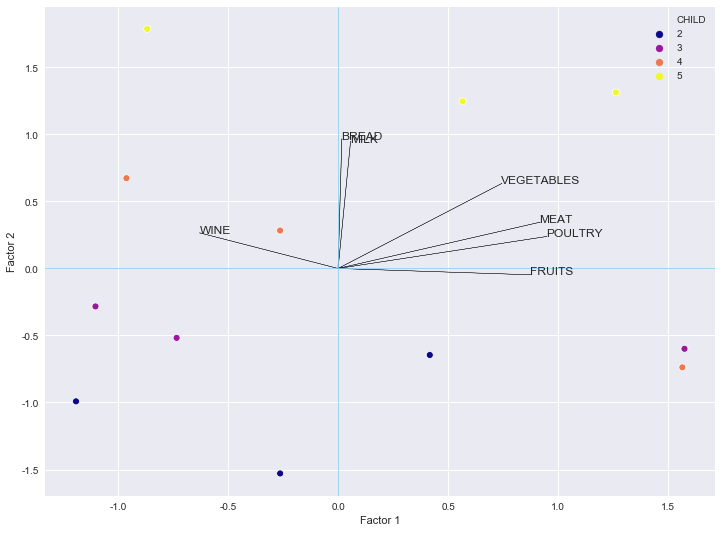

<Figure size 576x396 with 0 Axes>

In [13]:
plt.figure(figsize = (12, 9))
for i in range(7):
    if i == 0:
        plt.arrow(0, 0, fa.loadings_.T[0,i], fa.loadings_.T[1,i])
        plt.text(fa.loadings_.T[0,i] * 0.7, fa.loadings_.T[1,i], s = df.columns[i])
    else:
        plt.arrow(0, 0, fa.loadings_.T[0,i], fa.loadings_.T[1,i])
        plt.text(fa.loadings_.T[0,i] , fa.loadings_.T[1,i], s = df.columns[i])
        
plt.axvline(x =0, color = 'skyblue', linewidth = .8)
plt.axhline(y =0, color = 'skyblue', linewidth = .8)
plt.xlabel('Factor1')
plt.ylabel('Factor2')

fa_df2 = fa.fit_transform(df_scaled)[:,0:2]
fa_df2 = pd.DataFrame(data = fa_df2
             , columns = ['Factor 1', 'Factor 2'])
child = data_ch.loc[:,'CHILD']
child = pd.DataFrame(child, columns = ['CHILD'])
fa_df2['CHILD'] = child
fa_df2['CHILD'] = fa_df2['CHILD'].astype('int32')
sns.scatterplot(x = 'Factor 1', y = 'Factor 2', data = fa_df2, palette = 'plasma', hue = 'CHILD')
plt.show()
plt.savefig('biplot2.png', dpi = 2000)

In [14]:
data_ch

,BREAD,VEGETABLES,FRUITS,MEAT,POULTRY,MILK,WINE,CHILD
0,332,428,354,1437,526,247,427,2
1,293,559,388,1527,567,239,258,2
2,372,767,562,1948,927,235,433,2
3,406,563,341,1507,544,324,407,3
4,386,608,396,1501,558,319,363,3
5,438,843,689,2345,1148,243,341,3
6,534,660,367,1620,638,414,407,4
7,460,699,484,1856,762,400,416,4
8,385,789,621,2366,1149,304,282,4
9,655,776,423,1848,759,495,486,5


In [15]:
fa_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
Factor 1    12 non-null float64
Factor 2    12 non-null float64
CHILD       12 non-null int32
dtypes: float64(2), int32(1)
memory usage: 320.0 bytes
